In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [89]:
import pydotplus
from IPython.display import Image
from IPython.core.display import HTML 


## Функция для формирования csv-файла посылки на Kaggle

In [2]:
def write_to_submission_file(predicted_labels, out_file, train_num=891,
                    target='Survived', index_label="PassengerId"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(train_num + 1,
                                                  train_num + 1 +
                                                  predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)



In [49]:
train_df = pd.read_csv("titanic_train.csv") 
test_df = pd.read_csv("titanic_test.csv")

In [10]:
 train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [50]:
y = train_df['Survived'].astype('int')

In [11]:
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Frauenthal, Dr. Henry William",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [12]:
test_df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Riihivouri, Miss. Susanna Juhantytar Sanni""""",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [51]:
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna('S', inplace=True)
test_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

## Кодируем категориальные признаки Pclass, Sex, SibSp, Parch и Embarked с помощью техники One-Hot-Encoding.

In [52]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Pclass'], 
                                               prefix="PClass"),
                      pd.get_dummies(train_df['Sex'], prefix="Sex"),
                      pd.get_dummies(train_df['SibSp'], prefix="SibSp"),
                      pd.get_dummies(train_df['Parch'], prefix="Parch"),
                     pd.get_dummies(train_df['Embarked'], prefix="Embarked")],
                     axis=1)

test_df = pd.concat([test_df, pd.get_dummies(test_df['Pclass'], 
                                             prefix="PClass"),
                      pd.get_dummies(test_df['Sex'], prefix="Sex"),
                      pd.get_dummies(test_df['SibSp'], prefix="SibSp"),
                      pd.get_dummies(test_df['Parch'], prefix="Parch"),
                    pd.get_dummies(test_df['Embarked'], prefix="Embarked")],
                     axis=1)

In [53]:
train_df.drop(['Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 
               'Parch', 'Ticket', 'Cabin', 'Embarked', 'PassengerId'], 
              axis=1, inplace=True)
test_df.drop(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'PassengerId'], 
             axis=1, inplace=True)

In [46]:
test_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,34.5,7.8292,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,47.0,7.0000,0,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,62.0,9.6875,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
3,27.0,8.6625,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,22.0,12.2875,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [54]:
set(test_df.columns) - set(train_df.columns)

{'Parch_9'}

In [55]:
test_df.drop(['Parch_9'], axis= 1, inplace=True)

In [42]:
set(test_df.columns) - set(train_df.columns)

set()

In [56]:
train_df.shape, y.shape

((891, 24), (891,))

In [90]:
Tree_Best1 = DecisionTreeClassifier(random_state=17)

In [71]:
tree_deep_2 = DecisionTreeClassifier(max_depth=2, random_state=17).fit(train_df, y)
tree_deep_2 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [67]:
tree_deep_2.score(train_df, y)

0.79573512906846244

In [73]:
predictions = tree_deep_2.predict(test_df)

In [74]:
write_to_submission_file(predictions, 
                         'titanic_tree_depth2.csv')



In [78]:
export_graphviz(tree_deep_2, out_file='C:/projects/Python/mlcourse_open/Lesson3/Titanic_deep2.dot',
               feature_names=train_df.columns, filled=True)

In [79]:
!dot -Tpng C:/projects/Python/mlcourse_open/Lesson3/Titanic_deep2.dot -o C:/projects/Python/mlcourse_open/Lesson3/Titanic_deep2.png

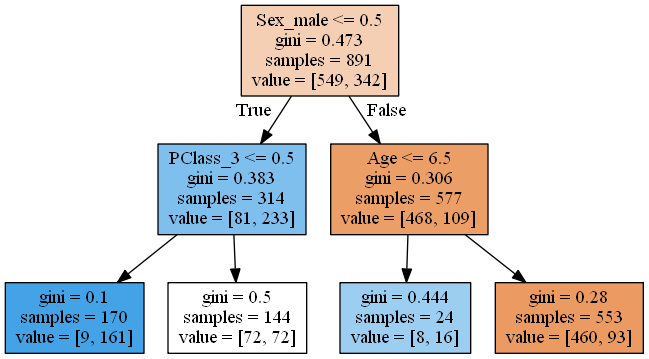

In [87]:
PATH = 'C:\projects\Python\mlcourse_open\Lesson3/'
Image(filename = PATH + "Titanic_deep2.png", width=800, height=800)

In [101]:
tree_params = {'max_depth': np.arange(1, 5), 
               'max_features':[.5, .7, 1.],
               'min_samples_leaf': np.arange(1, 5)}

In [102]:
tree_Grid  = GridSearchCV(Tree_Best1, tree_params, cv=5, n_jobs= -1)

In [103]:
%%time
tree_Grid.fit(train_df, y);

Wall time: 5.2 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([1, 2, 3, 4]), 'max_features': [0.5, 0.7, 1.0], 'min_samples_leaf': array([1, 2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [104]:
tree_Grid.best_params_, tree_Grid.best_score_

({'max_depth': 3, 'max_features': 1.0, 'min_samples_leaf': 3},
 0.81032547699214363)

In [106]:
Best_tree2 = DecisionTreeClassifier(max_depth=3,min_samples_leaf=3,random_state=17)
Best_tree2.fit(train_df, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [107]:
Best_tree2.score(train_df, y)

0.82379349046015715

In [111]:
predictions2 = Best_tree2.predict(test_df)

In [112]:
write_to_submission_file(predictions2, 
                         'Best_tree.csv')

## Небольшое отсупление метод разделения имени на слова и префиксы!